In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Conducir un análisis exploratorio sobre los datos en WAR_class_dev.csv. Visualice la distribución de las variables y de la variable objetivo. Verifique si hay valores
faltantes (NaN), datos duplicados o desbalanceo entre clases. Analice también la
posible presencia de correlaciones fuertes entre los features. (Pandas Cheat Sheet)

In [2]:
from Problema1.src.visualization import explore_data

df_dev = pd.read_csv("Problema2/data/raw/WAR_class_dev.csv")
df_test = pd.read_csv("Problema2/data/raw/WAR_class_test.csv")

explore_data(df_dev)

Fragmento aleatorio de muestras


,poss,mp,raptor_total,war_total,pace_impact,war_class
2729,1860.240735,1165.837638,-2.349827,0.349473,0.122057,2
6586,6667.491810,3279.167844,1.612648,7.416502,-0.052998,3
2897,4619.400881,2433.865684,-0.223296,3.775306,-0.055072,2
539,5750.380164,2932.007042,1.837976,6.643467,-1.009318,3
792,4946.309564,2564.889262,6.233268,10.755639,-0.579242,3
5397,2747.466580,1076.608596,-5.689382,-2.102723,0.523183,1
6581,6314.687690,2923.539183,3.020626,8.033059,-0.442204,3



Rango de valores de cada columna


,poss,mp,raptor_total,war_total,pace_impact,war_class
min,-414.390684,-235.333650,-43.449330,-6.589665,-6.935191,1.0
max,9329.401575,4264.461247,32.904816,28.762877,11.193450,3.0



Categorías con valores faltantes
 Series([], )

Filas duplicadas: 0


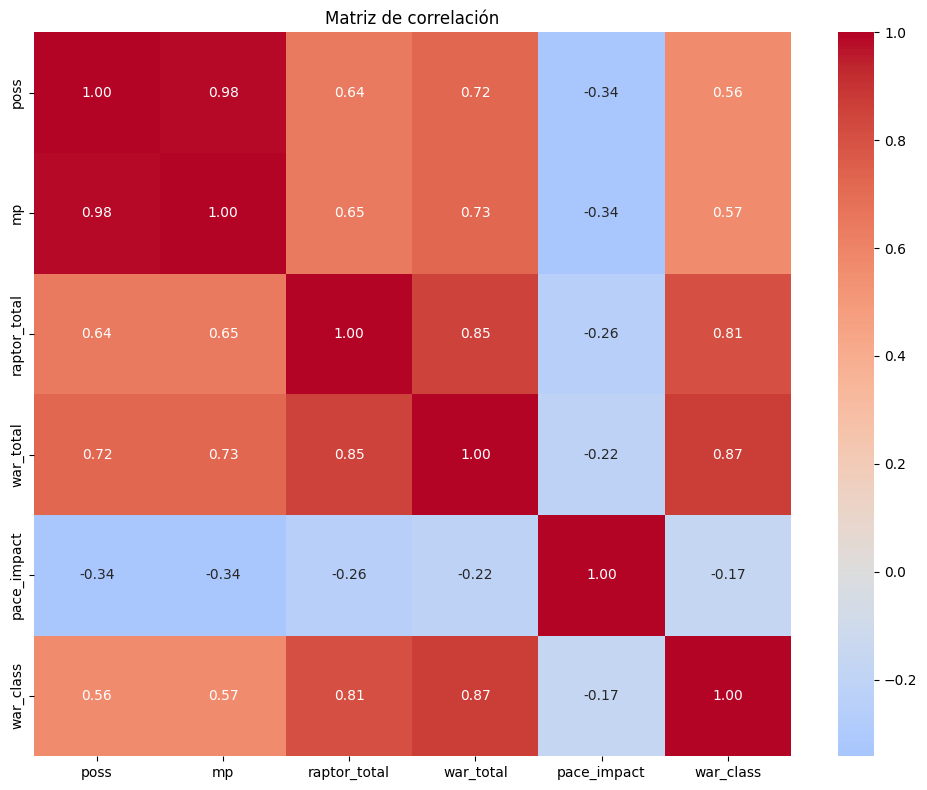

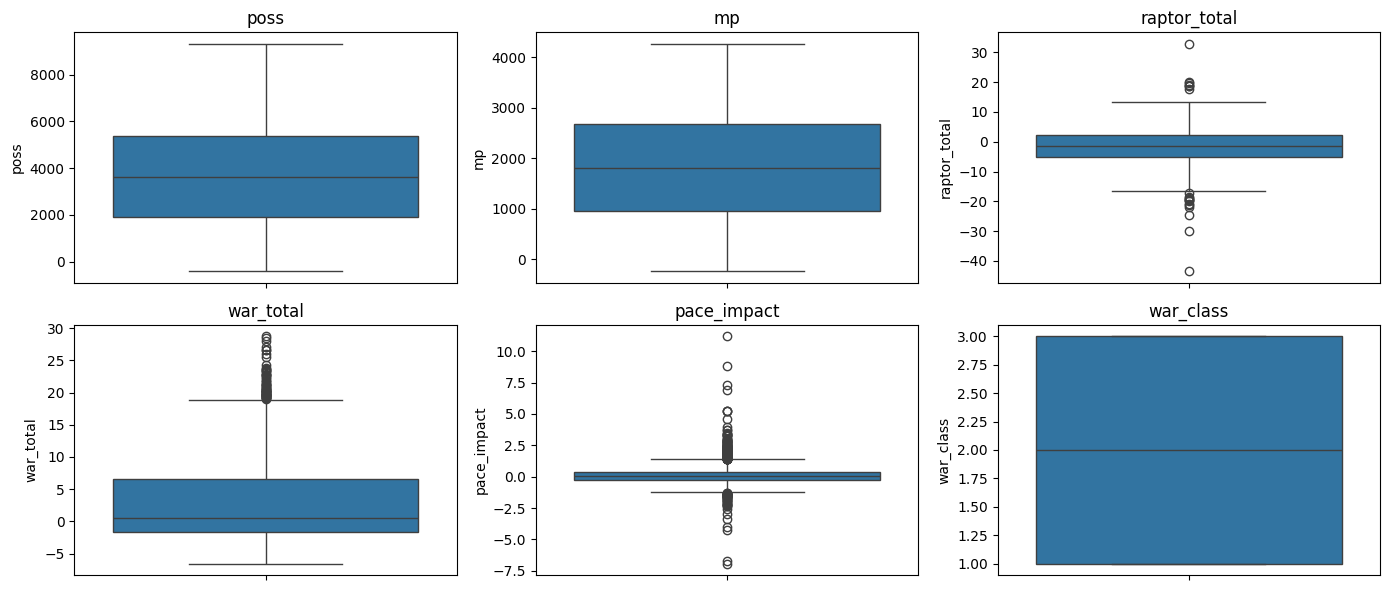

In [3]:
from Problema1.src.visualization import plot_correlation_matrix, plot_boxplots
plot_correlation_matrix(df_dev)
plot_boxplots(df_dev, ['Diagnosis', 'CellType', 'GeneticMutation'])
# sns.pairplot(df_dev, hue='war_class', diag_kind='kde', palette='Set2')

In [4]:
from Problema1.src.preprocessing import clean_outliers
from Problema1.src.preprocessing import train_val_split
from Problema1.src.preprocessing import smote
df_dev.drop(columns=["war_total"], inplace=True)
df_test.drop(columns=["war_total"], inplace=True)
limits = {'poss': (0, np.inf), 'mp': (0, np.inf)}
clean_outliers(df_dev, limits)
clean_outliers(df_test, limits)
df_dev.dropna(inplace=True)
df_test.dropna(inplace=True)

print(df_dev['war_class'].value_counts(normalize=True))
train, val = train_val_split(df_dev, split=0.8, shuffle=True)
train_smote = smote(train, 'war_class', k=5)
print(train_smote['war_class'].value_counts(normalize=True))

war_class
2    0.351396
3    0.340619
1    0.307984
Name: proportion, dtype: float64
war_class
3    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64


In [5]:
# Separar features y target
X_train = train_smote.drop("war_class", axis=1)
y_train = train_smote["war_class"]
X_val = val.drop("war_class", axis=1)
y_val = val["war_class"]
X_test = df_test.drop("war_class", axis=1)
y_test = df_test["war_class"]

In [6]:
from Problema1.src.preprocessing import robust_fit, robust_transform
print(y_train.value_counts())
print(y_val.value_counts())

# Features a escalar
features_robust = ['poss', 'mp', 'raptor_total', 'pace_impact']
# features_minmax = ['poss', 'mp', 'raptor_total', 'pace_impact']

# Fit con train
mediana, iqr = robust_fit(X_train[features_robust])
# minimos, maximos = minmax_fit(X_train[features_minmax])

# Transform
X_train[features_robust] = robust_transform(X_train[features_robust], mediana, iqr)
X_val[features_robust] = robust_transform(X_val[features_robust], mediana, iqr)
X_test[features_robust] = robust_transform(X_test[features_robust], mediana, iqr)

# X_train[features_minmax] = minmax_transform(X_train[features_minmax], minimos, maximos)
# X_val[features_minmax] = minmax_transform(X_val[features_minmax], minimos, maximos)
# X_test[features_minmax] = minmax_transform(X_test[features_minmax], minimos, maximos)

war_class
3    1826
2    1826
1    1826
Name: count, dtype: int64
war_class
2    489
3    420
1    409
Name: count, dtype: int64


LDA
Mejor F-score: 0.9037377872473974 con lr=0.1, lambda=0.001
Mejor F-score: 0.9621210992606073 con n_trees=20, max_depth=10, min_samples_split=2


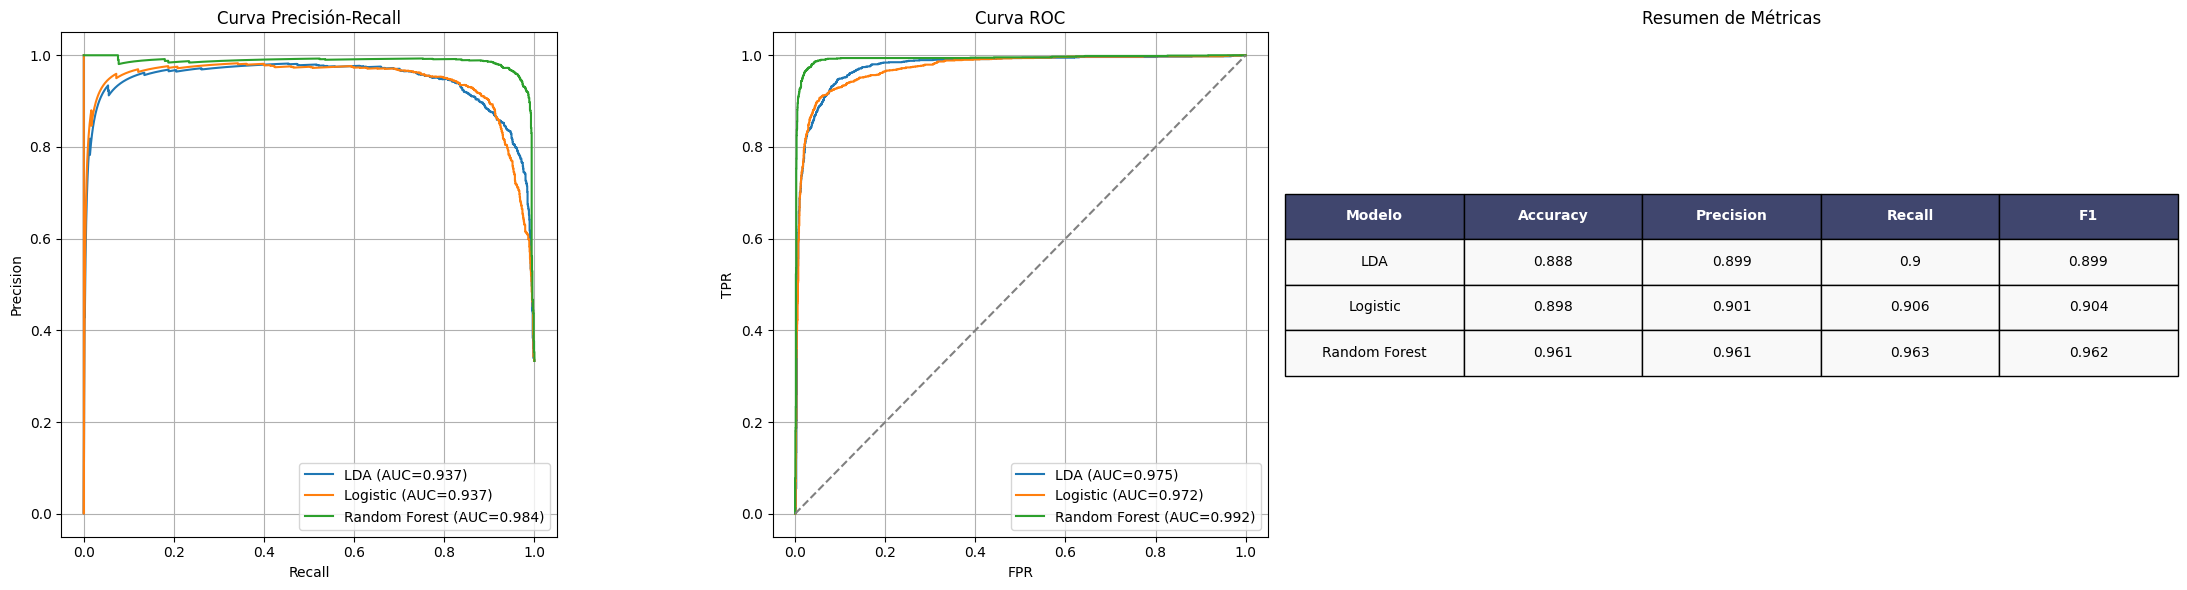

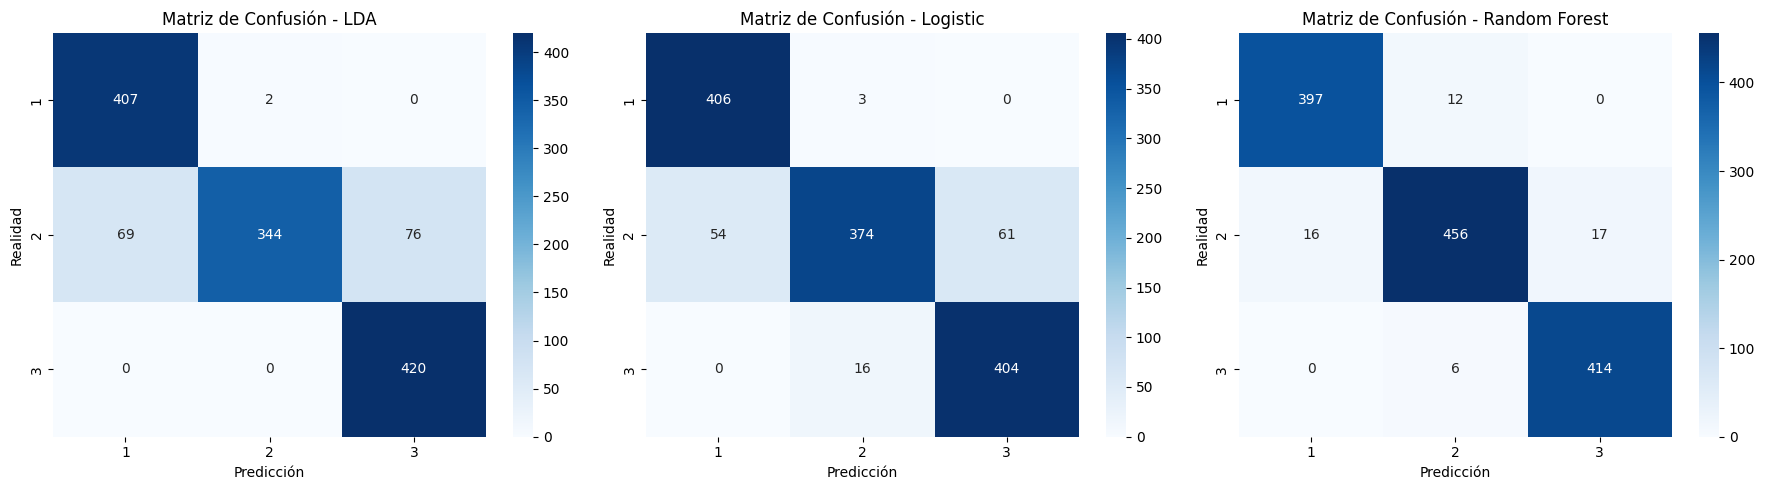

In [7]:
from Problema2.src.utils import train_best_random_forest, train_best_multiclass_logistic_model
from Problema2.src.models import LinearDiscriminantAnalysis
from Problema2.src.metrics import f_score
from Problema2.src.metrics import compare_confusion_matrices, compare_models_metrics

model_lda = LinearDiscriminantAnalysis(X_train, y_train)
print("LDA")
y_pred_lda = model_lda.predict(X_val)
y_prob_lda = model_lda.predict_proba(X_val)


model_logistic = train_best_multiclass_logistic_model(X_train, y_train, X_val, y_val)
y_pred_log = model_logistic.predict(X_val)
y_prob_log = model_logistic.predict_proba(X_val)

model_forest = train_best_random_forest(X_train, y_train, X_val, y_val)
y_pred_forest = model_forest.predict(X_val)
y_prob_forest = model_forest.predict_proba(X_val)

compare_models_metrics(
    [y_val]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)

compare_confusion_matrices(
    [y_val]*3,
    [y_pred_lda, y_pred_log, y_pred_forest]
)


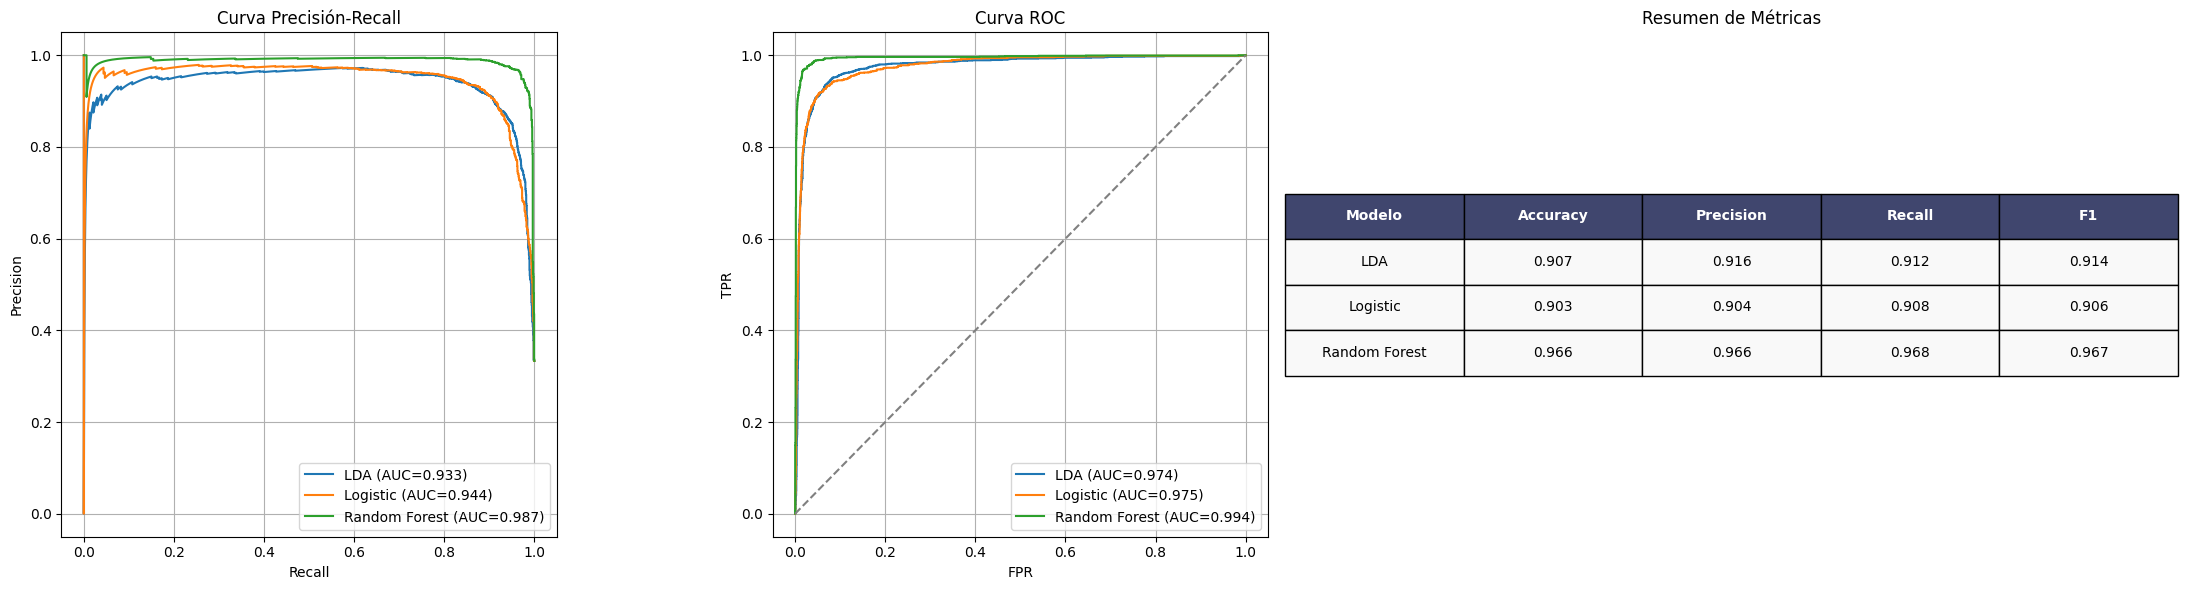

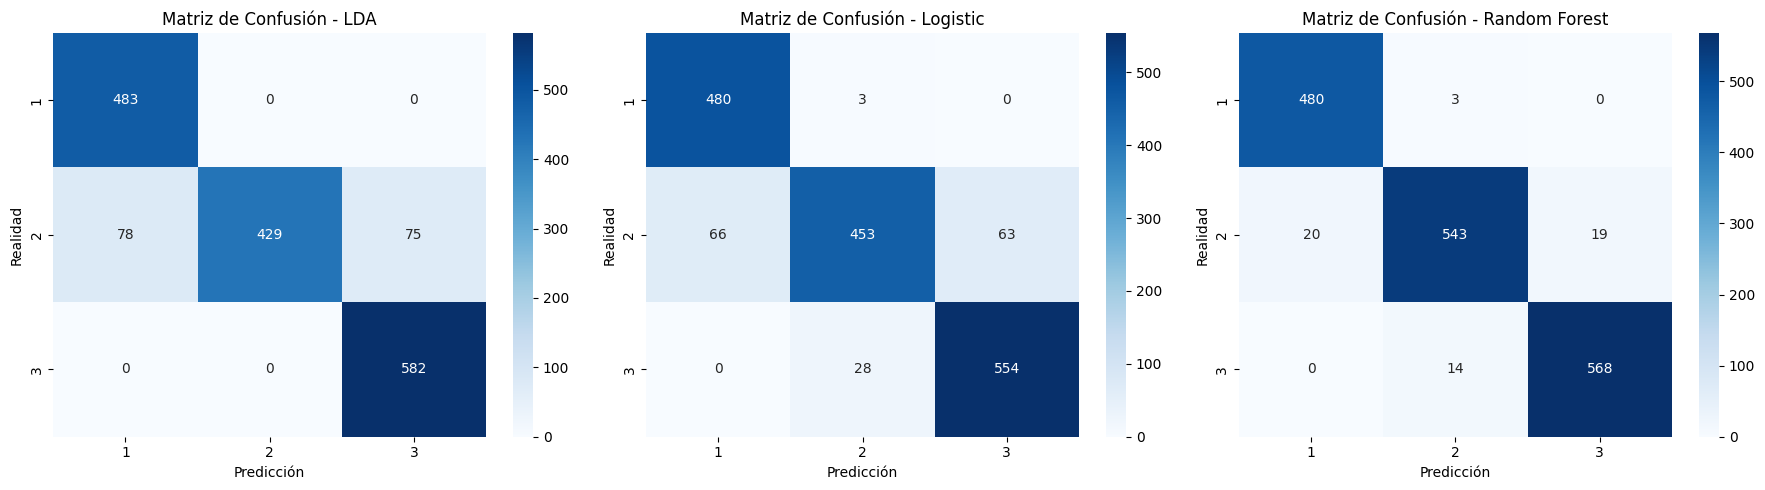

In [8]:
y_pred_lda = model_lda.predict(X_test)
y_prob_lda = model_lda.predict_proba(X_test)

y_pred_log = model_logistic.predict(X_test)
y_prob_log = model_logistic.predict_proba(X_test)

y_pred_forest = model_forest.predict(X_test)
y_prob_forest = model_forest.predict_proba(X_test)

compare_models_metrics(
    [y_test]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)

compare_confusion_matrices(
    [y_test]*3,
    [y_pred_lda, y_pred_log, y_pred_forest]
)


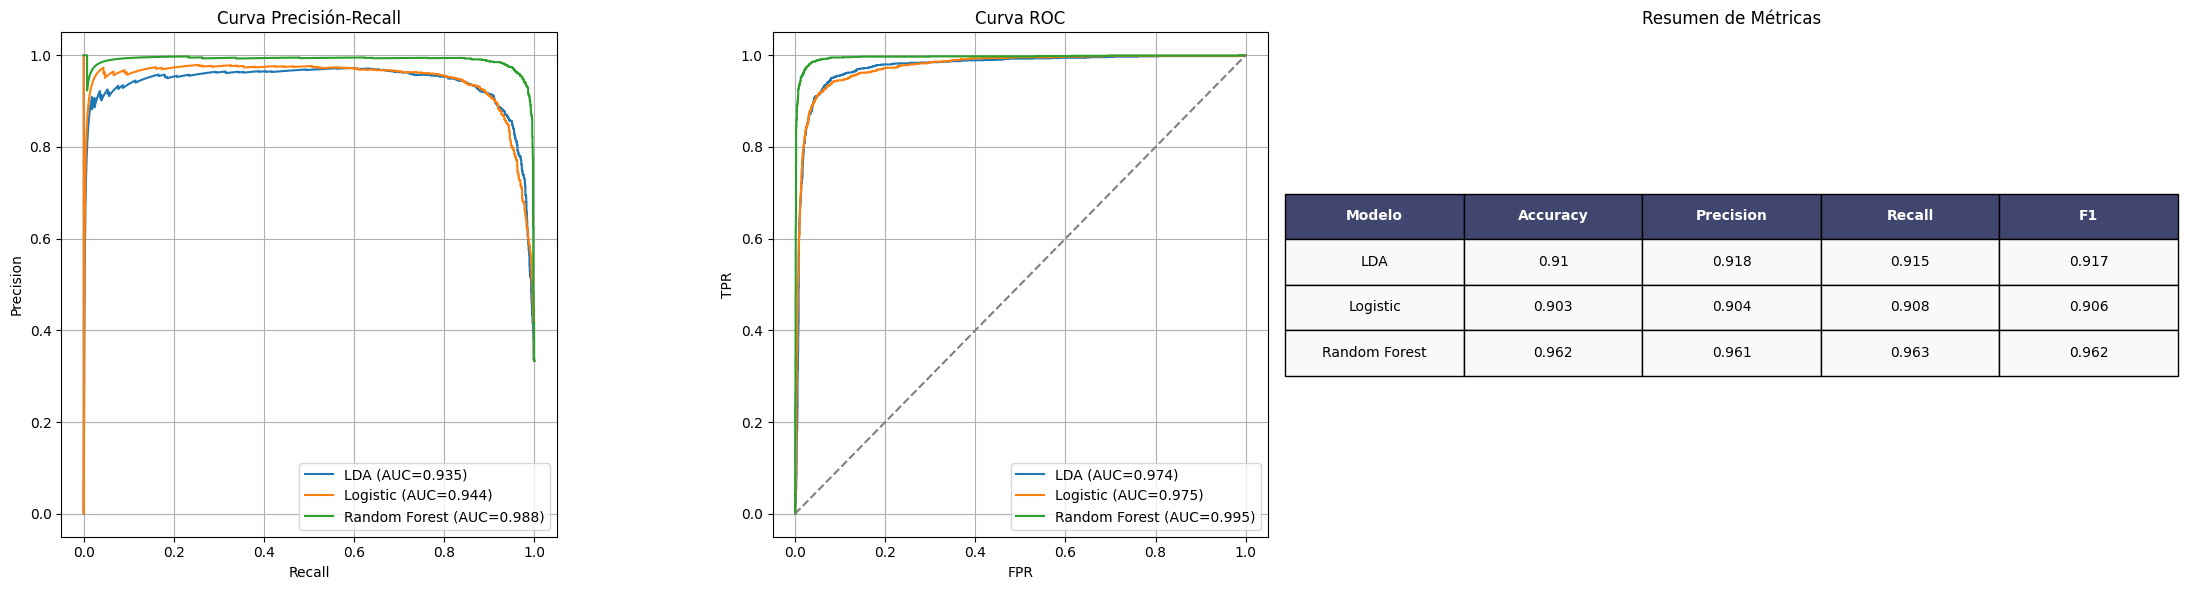

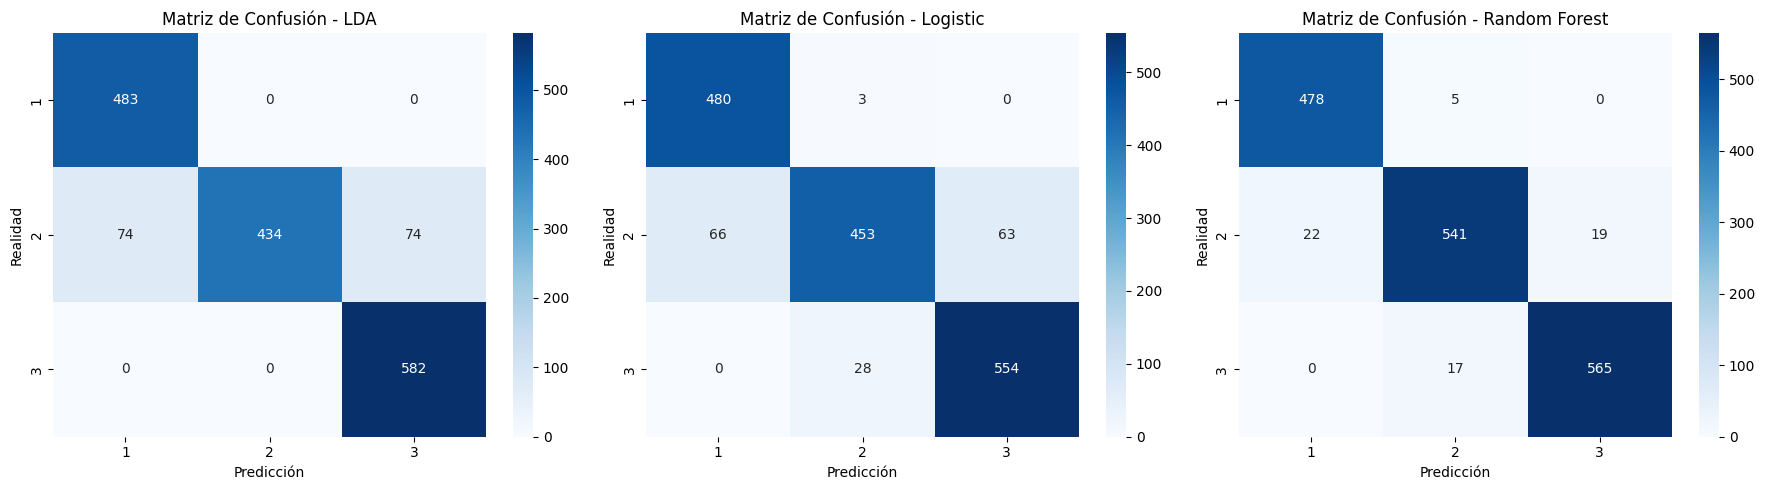

In [9]:
from Problema2.src.models import RandomForest, MulticlassLogisticRegression
X_dev = pd.concat([X_train, X_val], axis=0)
y_dev = pd.concat([y_train, y_val], axis=0)

model_lda = LinearDiscriminantAnalysis(X_dev, y_dev)
model_log = MulticlassLogisticRegression(X_dev, y_dev, lr=0.1, L2=0.001)
model_forest = model = RandomForest(n_trees=20, max_depth=10, min_samples_split=2)
model_forest.fit(X_dev, y_dev)

y_pred_lda = model_lda.predict(X_test)
y_prob_lda = model_lda.predict_proba(X_test)

y_pred_log = model_logistic.predict(X_test)
y_prob_log = model_logistic.predict_proba(X_test)

y_pred_forest = model_forest.predict(X_test)
y_prob_forest = model_forest.predict_proba(X_test)

compare_models_metrics(
    [y_test]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)

compare_confusion_matrices(
    [y_test]*3,
    [y_pred_lda, y_pred_log, y_pred_forest]
)
